# Preparation

First, we will excute the command in the terminal

`mongoexport --uri=xxxxxxxxxxxxxxx --collection=sales --out="finalproject.json"`


Given that our data is in JSON format, we need to transition it to the more accessible CSV format for efficient querying. This process is slightly complex because JSON often has nested structures. By focusing on the "item" as our main entity, we can flatten the data. However, this method can lead to repeated information, potentially using more storage space.

In [31]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns



# Load the JSON data as multiple objects
with open('finalproject.json', 'r') as f:
    lines = f.readlines()
    data = [json.loads(line) for line in lines if line.strip() != ""]

# Process each JSON object and store the results in a list
all_items = []

for entry in data:
    # Expand the items list into its own DataFrame
    items_df = pd.json_normalize(entry, record_path='items', meta=['_id', 'saleDate', 'storeLocation', 'customer', 'couponUsed', 'purchaseMethod'])

    # Convert price from dictionary to float
    items_df['price'] = items_df['price.$numberDecimal'].astype(float)
    # Drop the old price column
    items_df.drop(columns=['price.$numberDecimal'], inplace=True)

    all_items.append(items_df)

# Concatenate all DataFrames into one
final_df = pd.concat(all_items, ignore_index=True)

# Save the final DataFrame to CSV
final_df.to_csv('finalproject_items.csv', index=False)


In [32]:
df = pd.read_csv('finalproject_items.csv')

df.head()


,name,tags,quantity,_id,saleDate,storeLocation,customer,couponUsed,purchaseMethod,price
0,notepad,"['office', 'writing', 'school']",1,{'$oid': '5bd761dcae323e45a93ccfea'},{'$date': '2017-06-22T09:54:14.185Z'},Denver,"{'gender': 'M', 'age': 51, 'email': 'worbiduh@...",False,In store,30.08
1,binder,"['school', 'general', 'organization']",7,{'$oid': '5bd761dcae323e45a93ccfea'},{'$date': '2017-06-22T09:54:14.185Z'},Denver,"{'gender': 'M', 'age': 51, 'email': 'worbiduh@...",False,In store,24.68
2,notepad,"['office', 'writing', 'school']",4,{'$oid': '5bd761dcae323e45a93ccfea'},{'$date': '2017-06-22T09:54:14.185Z'},Denver,"{'gender': 'M', 'age': 51, 'email': 'worbiduh@...",False,In store,32.10
3,pens,"['writing', 'office', 'school', 'stationary']",3,{'$oid': '5bd761dcae323e45a93ccfea'},{'$date': '2017-06-22T09:54:14.185Z'},Denver,"{'gender': 'M', 'age': 51, 'email': 'worbiduh@...",False,In store,31.41
4,printer paper,"['office', 'stationary']",3,{'$oid': '5bd761dcae323e45a93ccfea'},{'$date': '2017-06-22T09:54:14.185Z'},Denver,"{'gender': 'M', 'age': 51, 'email': 'worbiduh@...",False,In store,43.56


# Top 10 product names by sales

Note : There's only 7 unique items in the entire database so it's gonna be top 7.

name
laptop           6775977.07
backpack          817374.10
pens              581843.27
binder            511644.57
notepad           463615.48
envelopes         376658.49
printer paper     367459.29
Name: total_sales, dtype: float64


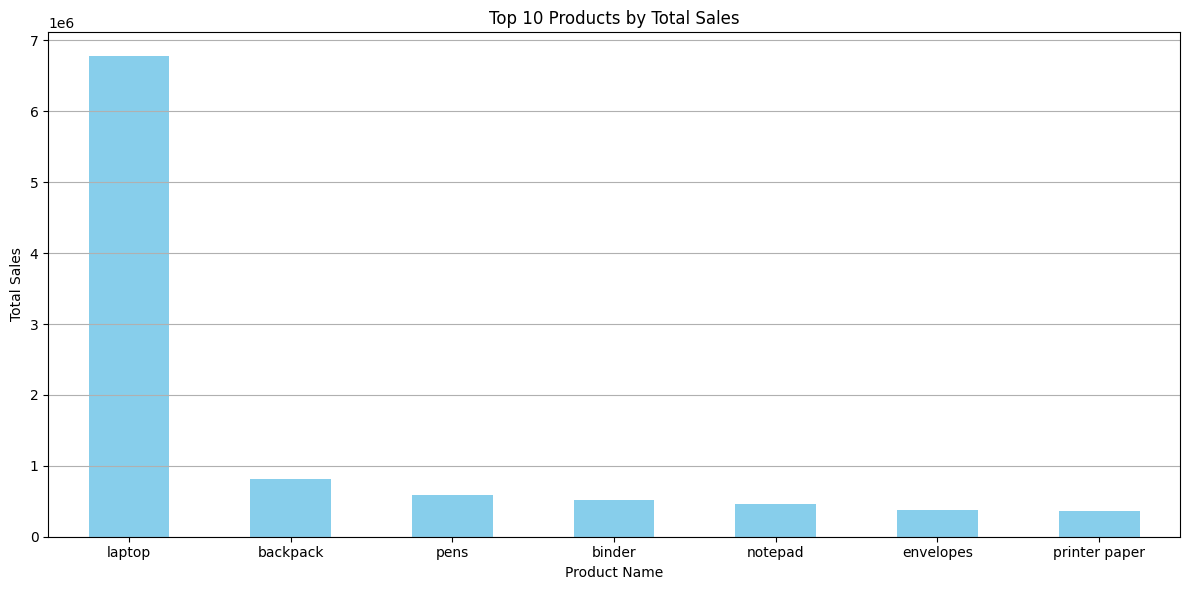

In [33]:
df['total_sales'] = df['quantity'] * df['price']
top_10_products = df.groupby('name')['total_sales'].sum().sort_values(ascending=False).head(10)

# Create a bar chart
top_10_products.plot(kind='bar', figsize=(12, 6), color='skyblue')

# Set title and labels for axes
plt.title("Top 10 Products by Total Sales")
plt.xlabel("Product Name")
plt.ylabel("Total Sales")
plt.xticks(rotation=0)
plt.grid(axis='y')

# Display the plot
plt.tight_layout()

print(top_10_products)
plt.show()


# Top 3 Products sales by store location

   storeLocation      name  total_sales
0         Austin    laptop   1018494.05
1         Austin  backpack    115217.59
2         Austin      pens     74622.52
3         Denver    laptop   1961659.25
4         Denver  backpack    245679.34
5         Denver      pens    185008.39
6         London    laptop   1073098.72
7         London  backpack    144529.14
8         London      pens     92602.30
9       New York    laptop    694613.32
10      New York  backpack     82563.14
11      New York      pens     64029.90
12     San Diego    laptop    462973.58
13     San Diego  backpack     50997.42
14     San Diego      pens     42134.55
15       Seattle    laptop   1565138.15
16       Seattle  backpack    178387.47
17       Seattle      pens    123445.61


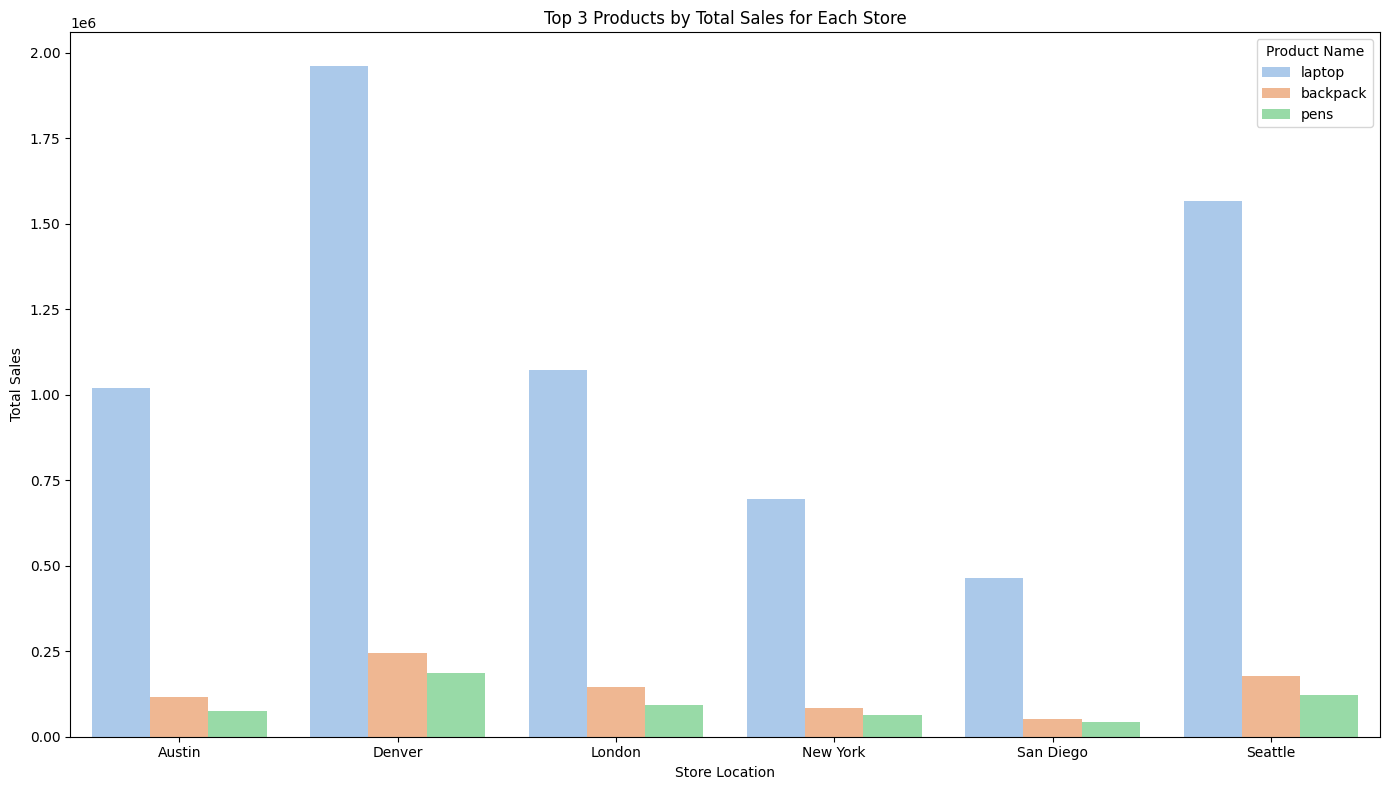

In [34]:
store_product_sales = df.groupby(['storeLocation', 'name'])['total_sales'].sum().reset_index()
top_3_by_store = store_product_sales.groupby('storeLocation').apply(lambda x: x.nlargest(3, 'total_sales')).reset_index(drop=True)
print(top_3_by_store)

# Set up the figure and axis
plt.figure(figsize=(14, 8))

# Create a grouped bar chart
sns.barplot(data=top_3_by_store, x='storeLocation', y='total_sales', hue='name', palette='pastel')

# Set title and labels for axes
plt.title('Top 3 Products by Total Sales for Each Store')
plt.xlabel('Store Location')
plt.ylabel('Total Sales')
plt.xticks(rotation=0)
plt.legend(title="Product Name", loc='upper right')

# Display the plot
plt.tight_layout()
plt.show()

# Ranking of each location by sales

In [35]:
store_rankings = df.groupby('storeLocation')['total_sales'].sum().sort_values(ascending=False)
print(store_rankings)

storeLocation
Denver       2921009.92
Seattle      2255947.69
London       1583066.79
Austin       1445603.11
New York     1016059.59
San Diego     672885.17
Name: total_sales, dtype: float64


# Purchase methods by gender table

In [36]:
# Extract the gender from the 'customer' column
df['gender'] = df['customer'].str.extract("'gender': '(\w)'")[0]

# Pivot table
pivot_table = df.groupby(['gender', 'purchaseMethod']).size().unstack().fillna(0)

pivot_table.index.name = None
pivot_table.columns.name = None

print(pivot_table)


   In store  Online  Phone
F      8062    4270   1499
M      7571    4314   1722


# Monthly Total Sales

saleDate
2013-01    196043.76
2013-02    147622.59
2013-03    140700.06
2013-04    162336.67
2013-05    179143.37
2013-06    142132.02
2013-07    176298.23
2013-08    130977.22
2013-09    137871.99
2013-10    173126.73
2013-11    148358.38
2013-12    174306.96
2014-01    125824.02
2014-02    141174.41
2014-03    193413.50
2014-04    132593.08
2014-05    166896.80
2014-06    143304.56
2014-07    184804.60
2014-08    167979.81
2014-09    159802.92
2014-10    149284.84
2014-11    180564.85
2014-12    139466.83
2015-01    222538.97
2015-02    189776.15
2015-03    178086.94
2015-04    132298.50
2015-05    167482.69
2015-06    149484.34
2015-07    149510.47
2015-08    154868.63
2015-09    135615.80
2015-10    175215.34
2015-11    158390.42
2015-12    166565.02
2016-01    166558.93
2016-02    120783.52
2016-03    193185.17
2016-04    137340.27
2016-05    162966.06
2016-06    132942.54
2016-07    180331.10
2016-08    164482.37
2016-09    138299.53
2016-10    151698.93
2016-11    170758.41
2016

/var/folders/c_/6y5mqbbs2613c28614lp7czc0000gn/T/ipykernel_77050/1223022403.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  monthly_sales = df.groupby(df['saleDate'].dt.to_period("M"))['total_sales'].sum()


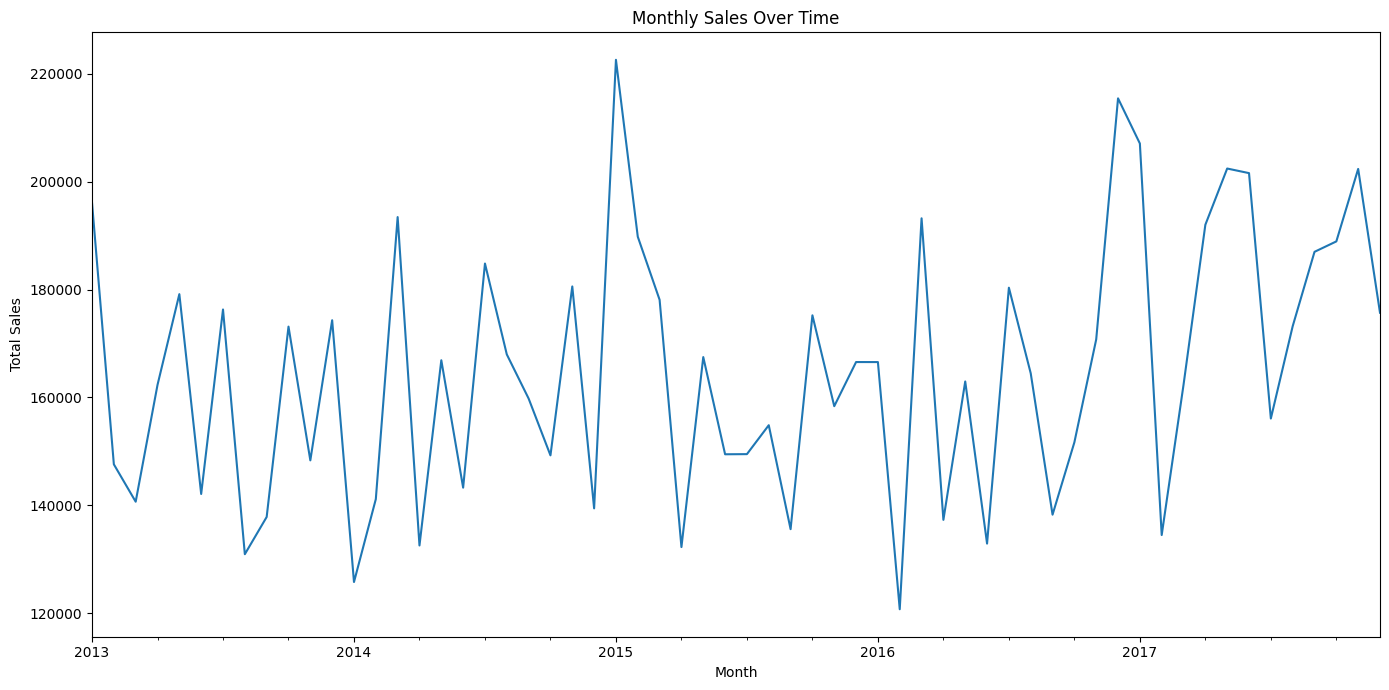

In [37]:
# Extract and convert the saleDate
df['saleDate'] = pd.to_datetime(df['saleDate'].str.extract("{'\$date': '([^']+)'}")[0], errors='coerce')

# Group by month and sum the sales
monthly_sales = df.groupby(df['saleDate'].dt.to_period("M"))['total_sales'].sum()
print(monthly_sales)

plt.figure(figsize=(14, 7))
monthly_sales.plot()
plt.title('Monthly Sales Over Time')
plt.ylabel('Total Sales')
plt.xlabel('Month')
plt.grid(False)
plt.tight_layout()
plt.show()


# Extra Analysis

In [38]:
# Extract satisfaction from the 'customer' column
df['satisfaction'] = df['customer'].str.extract("'satisfaction': (\d+)").astype(float)

# Group by store location and calculate average satisfaction
average_satisfaction_by_location = df.groupby('storeLocation')['satisfaction'].mean().sort_values(ascending=False)

print(average_satisfaction_by_location)


storeLocation
New York     3.802756
London       3.796815
Denver       3.787000
Seattle      3.771279
Austin       3.767442
San Diego    3.741935
Name: satisfaction, dtype: float64


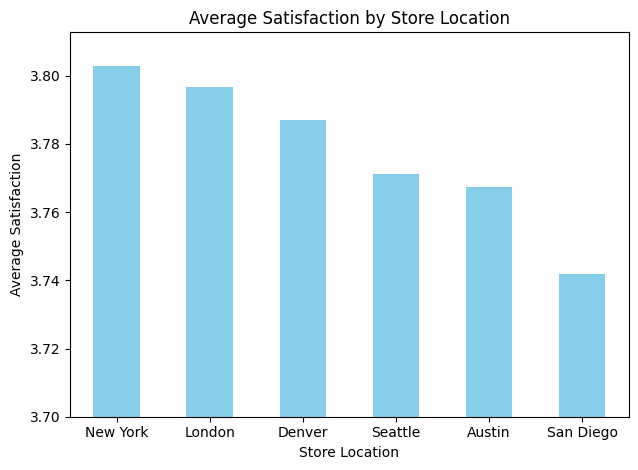

In [39]:
# Plotting
average_satisfaction_by_location.plot(kind='bar', color='skyblue', edgecolor='none')
plt.title('Average Satisfaction by Store Location')
plt.xlabel('Store Location')
plt.ylabel('Average Satisfaction')
plt.xticks(rotation=0)
plt.tight_layout()
plt.ylim([3.7, average_satisfaction_by_location.max() + 0.01])
plt.show()